Generating synthetic data using Uniform distribution...
Generating synthetic data using Normal distribution...
Generating synthetic data using Poisson distribution...
Generating synthetic data using Exponential distribution...
Generating synthetic data using Log-Normal distribution...
Generating synthetic data using Beta distribution...
Generating synthetic data using Chi-Squared distribution...
Generating synthetic data using Geometric distribution...
Generating synthetic data using Gamma distribution...
Calculating p-values for real data...
Shape of real_p_values: (41093,)
First 5 p-values: [0.83003047 0.40871613 0.75394928 0.72724056 0.97983274]

Processing real data across multiple thresholds...
Number of significant genes in real data before and after FDR correction across thresholds:
Threshold = 0.05: Before FDR = 1376, After FDR = 31
Threshold = 0.10: Before FDR = 2606, After FDR = 39
Threshold = 0.15: Before FDR = 3807, After FDR = 47
Threshold = 0.20: Before FDR = 5037, After 

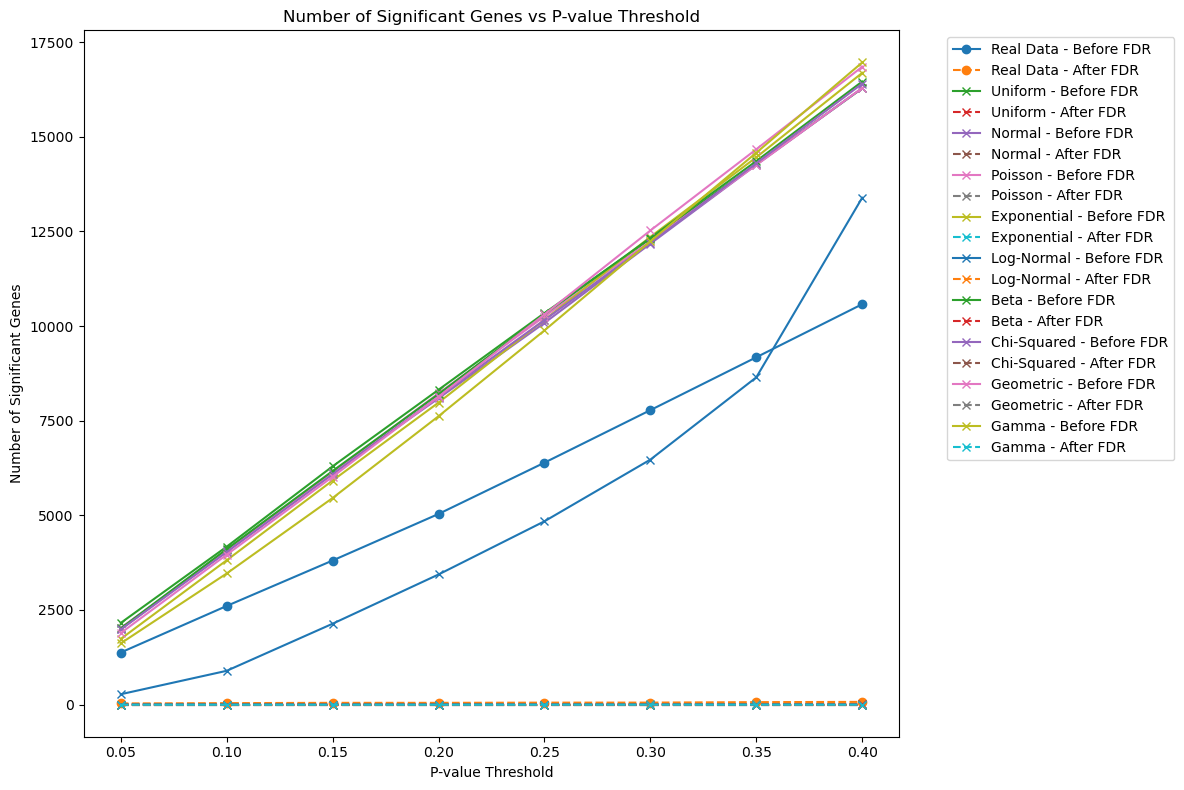

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, ks_2samp
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt

def split_row_by_gender_and_smoking_status(row):
    """
    Splits a row into four groups based on gender and smoking status.
    """
    male_non_smoker = row.iloc[1:13].tolist()
    male_smoker = row.iloc[13:25].tolist()
    female_non_smoker = row.iloc[25:37].tolist()
    female_smoker = row.iloc[37:49].tolist()

    return np.array(male_non_smoker), np.array(male_smoker), np.array(female_non_smoker), np.array(female_smoker)

def calculate_p_val(A):
    """
    Calculates the p-value using One-Way ANOVA for the given data.
    """
    # Define the number of samples per group
    samples_per_group = 12  # Adjust this if your group sizes differ

    # Split the concatenated array back into individual groups
    male_non_smoker = A[0:samples_per_group]
    male_smoker = A[samples_per_group:2*samples_per_group]
    female_non_smoker = A[2*samples_per_group:3*samples_per_group]
    female_smoker = A[3*samples_per_group:4*samples_per_group]

    # Check for constant input arrays
    if (np.var(male_non_smoker) == 0 or np.var(male_smoker) == 0 or
        np.var(female_non_smoker) == 0 or np.var(female_smoker) == 0):
        return 1  # Return a high p-value indicating no significant difference

    # Perform One-Way ANOVA
    stat, p = f_oneway(male_smoker, male_non_smoker, female_smoker, female_non_smoker)

    return p

def run_main_algo(df):
    """
    Processes the dataframe to calculate p-values for each probe.
    Returns:
        p_values_array (np.array): Array of p-values for each probe.
        probe_names (list): List of probe names.
    """
    p_values = []
    probe_names = []
    for index, row in df.iterrows():
        probe_names.append(row['ProbeName'])
        male_non_smoker, male_smoker, female_non_smoker, female_smoker = split_row_by_gender_and_smoking_status(row)
        # Concatenate all groups into a 1D array
        A = np.concatenate((male_smoker, male_non_smoker, female_smoker, female_non_smoker))
        p_values.append(calculate_p_val(A))

    p_values_array = np.array(p_values)
    return p_values_array, probe_names

def perform_ks_test(real_p_values, random_p_values, distribution_name):
    """
    Performs the Kolmogorov-Smirnov test between real and random p-values.
    """
    # Perform the KS test
    stat, p_value = ks_2samp(real_p_values, random_p_values)
    print(f"KS Test between real data and {distribution_name} data:")
    print(f"KS Statistic: {stat:.4f}, P-value: {p_value:.4e}\n")

def generate_synthetic_data(df_real, distribution_params):
    """
    Generates synthetic datasets based on specified distributions and their parameters.
    Args:
        df_real (pd.DataFrame): The real gene expression data.
        distribution_params (dict): Parameters for each distribution.
    Returns:
        dict: A dictionary of synthetic dataframes keyed by distribution names.
    """
    synthetic_dfs = {}
    num_samples, num_features = df_real.shape

    for dist_name, params in distribution_params.items():
        print(f"Generating synthetic data using {dist_name} distribution...")
        df_random = df_real.copy()
        for col in df_random.columns[1:]:
            if dist_name == 'Beta':
                # Beta distribution outputs values between 0 and 1, so scale to match data range
                beta_data = distributions[dist_name](size=df_random.shape[0], **params)
                df_random[col] = beta_data * (high_uniform - low_uniform) + low_uniform
            elif dist_name in ['Poisson', 'Geometric', 'Chi-Squared', 'Gamma']:
                df_random[col] = distributions[dist_name](size=df_random.shape[0], **params)
            elif dist_name == 'Log-Normal':
                df_random[col] = distributions[dist_name](mean=params['mean'], sigma=params['sigma'], size=df_random.shape[0])
            else:
                df_random[col] = distributions[dist_name](size=df_random.shape[0], **params)
        synthetic_dfs[dist_name] = df_random
    return synthetic_dfs

# Load the real data
df_real = pd.read_csv('Raw Data_GeneSpring.txt', sep='\t')
df_real = df_real.iloc[:, :-3]  # Drop last 3 unnecessary columns

# Extract gene expression data
gene_expression = df_real.iloc[:, 1:]  # Assuming first column is 'ProbeName'

# Define Uniform distribution parameters
low_uniform = 0.0000
high_uniform = 19.5638

# Fitted Parameters
overall_mean = 6.8050
overall_std = 4.1252
overall_min = 0.0000
overall_max = 19.5638

# Log-Normal Parameters
mu_lognorm = 0.0549
sigma_lognorm = 5.0844

# Beta Distribution Parameters
alpha_beta = 0.3942
beta_beta = 1.0338

# Gamma Distribution Parameters (Shifted Data)
shape_gamma = 0.3594
scale_gamma = 18.9329

# Poisson Distribution Parameter
lambda_poisson = 6.8050

# Geometric Distribution Parameter
p_geometric = 0.1281

# Exponential Distribution Parameter
scale_exponential = 6.8050

# Chi-Squared Distribution Parameter
df_chi_squared = 6.8050

# Normal Distribution Parameters
mean_normal = 6.8050
std_normal = 4.1252

# Define the range of p-value thresholds
thresholds = np.arange(0.05, 0.45, 0.05)  # 0.05, 0.10, ..., 0.40

# Define distributions and their corresponding parameters
distributions = {
    'Uniform': np.random.uniform,
    'Normal': np.random.normal,
    'Poisson': np.random.poisson,
    'Exponential': np.random.exponential,
    'Log-Normal': np.random.lognormal,
    'Beta': np.random.beta,
    'Chi-Squared': np.random.chisquare,
    'Geometric': np.random.geometric,
    'Gamma': np.random.gamma
}

# Parameters for each distribution
distribution_params = {
    'Uniform': {'low': low_uniform, 'high': high_uniform},
    'Normal': {'loc': mean_normal, 'scale': std_normal},
    'Poisson': {'lam': lambda_poisson},
    'Exponential': {'scale': scale_exponential},
    'Log-Normal': {'mean': mu_lognorm, 'sigma': sigma_lognorm},
    'Beta': {'a': alpha_beta, 'b': beta_beta},
    'Chi-Squared': {'df': df_chi_squared},
    'Geometric': {'p': p_geometric},  # Adjust 'p' as needed to match data characteristics
    'Gamma': {'shape': shape_gamma, 'scale': scale_gamma}  # Adjust 'shape' and 'scale' to match data
}

# Generate synthetic datasets for each distribution
synthetic_dfs = generate_synthetic_data(df_real, distribution_params)

# Calculate p-values for real data
print("Calculating p-values for real data...")
real_p_values, probe_names = run_main_algo(df_real)

# Verify the shape of real_p_values
print(f"Shape of real_p_values: {real_p_values.shape}")
print(f"First 5 p-values: {real_p_values[:5]}\n")

# Initialize dictionaries to store p-values and significant counts
random_p_values_dict = {}
significant_genes_before_fdr_dict = {}
significant_genes_after_fdr_dict = {}
significant_genes_real_before_fdr = {}
significant_genes_real_after_fdr = {}

# Calculate p-values for real data (before and after FDR correction across thresholds)
print("Processing real data across multiple thresholds...")
significant_genes_before_fdr_real = {}
significant_genes_after_fdr_real = {}

for threshold in thresholds:
    # Count significant genes before FDR correction (raw p-values < threshold)
    count_before = np.sum(real_p_values < threshold)
    significant_genes_before_fdr_real[threshold] = count_before

    # Apply FDR correction to real data with current threshold
    _, adjusted_p_values_real, _, _ = multipletests(real_p_values, alpha=threshold, method='fdr_bh')
    count_after = np.sum(adjusted_p_values_real < threshold)
    significant_genes_after_fdr_real[threshold] = count_after

print(f"Number of significant genes in real data before and after FDR correction across thresholds:")
for threshold in thresholds:
    print(f"Threshold = {threshold:.2f}: Before FDR = {significant_genes_before_fdr_real[threshold]}, After FDR = {significant_genes_after_fdr_real[threshold]}")

print("\n")

# Function to apply FDR correction and count significant genes
def apply_fdr_and_count(p_values, threshold):
    """
    Applies FDR correction and counts the number of significant genes.
    Args:
        p_values (np.array): Array of p-values.
        threshold (float): Significance threshold (alpha).
    Returns:
        count_before (int): Number of genes with raw p-value < threshold.
        count_after (int): Number of genes with adjusted p-value < threshold.
    """
    count_before = np.sum(p_values < threshold)
    _, adjusted_p_values, _, _ = multipletests(p_values, alpha=threshold, method='fdr_bh')
    count_after = np.sum(adjusted_p_values < threshold)
    return count_before, count_after

# Initialize summary dictionaries
summary_before_fdr = {'Real Data': significant_genes_before_fdr_real}
summary_after_fdr = {'Real Data': significant_genes_after_fdr_real}

# Iterate over each distribution
for dist_name, df_random in synthetic_dfs.items():
    print(f"Analyzing synthetic data generated from {dist_name} distribution...")
    # Calculate p-values for synthetic data
    random_p_values, _ = run_main_algo(df_random)
    random_p_values_dict[dist_name] = random_p_values

    # Initialize dictionaries to store counts for this distribution
    significant_genes_before_fdr_dict[dist_name] = {}
    significant_genes_after_fdr_dict[dist_name] = {}

    for threshold in thresholds:
        count_before, count_after = apply_fdr_and_count(random_p_values, threshold)
        significant_genes_before_fdr_dict[dist_name][threshold] = count_before
        significant_genes_after_fdr_dict[dist_name][threshold] = count_after

    # Store in summary dictionaries
    summary_before_fdr[dist_name] = significant_genes_before_fdr_dict[dist_name]
    summary_after_fdr[dist_name] = significant_genes_after_fdr_dict[dist_name]

    # Perform KS test between real data and current random data
    perform_ks_test(real_p_values, random_p_values, dist_name)

# Summarize the results
print("Summary of Significant Genes Across Thresholds:")
print("Number of significant genes before and after FDR correction for each threshold.\n")

# Create a DataFrame for real data
df_real_summary = pd.DataFrame({
    'Threshold': thresholds,
    'Before FDR Correction': [significant_genes_before_fdr_real[t] for t in thresholds],
    'After FDR Correction': [significant_genes_after_fdr_real[t] for t in thresholds]
})

print("Real Data:")
print(df_real_summary)

print("\nSynthetic Data:")
for dist_name in distributions.keys():
    df_synthetic_summary = pd.DataFrame({
        'Threshold': thresholds,
        'Before FDR Correction': [significant_genes_before_fdr_dict[dist_name][t] for t in thresholds],
        'After FDR Correction': [significant_genes_after_fdr_dict[dist_name][t] for t in thresholds]
    })
    print(f"\n{dist_name} Distribution:")
    print(df_synthetic_summary)

# Optional: Visualize the number of significant genes vs threshold
plt.figure(figsize=(12, 8))

# Plot for Real Data
plt.plot(df_real_summary['Threshold'], df_real_summary['Before FDR Correction'], marker='o', label='Real Data - Before FDR')
plt.plot(df_real_summary['Threshold'], df_real_summary['After FDR Correction'], marker='o', linestyle='--', label='Real Data - After FDR')

# Plot for Synthetic Data
for dist_name in distributions.keys():
    plt.plot(significant_genes_before_fdr_dict[dist_name].keys(),
             significant_genes_before_fdr_dict[dist_name].values(),
             marker='x', linestyle='-', label=f'{dist_name} - Before FDR')
    plt.plot(significant_genes_after_fdr_dict[dist_name].keys(),
             significant_genes_after_fdr_dict[dist_name].values(),
             marker='x', linestyle='--', label=f'{dist_name} - After FDR')

plt.xlabel('P-value Threshold')
plt.ylabel('Number of Significant Genes')
plt.title('Number of Significant Genes vs P-value Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
